# High School Longitudinal Study Data Analysis: Academic Performance as Related to Family Income, Poverty, and Race
- Ursatech Jupyter Notebook
- 12 November 2020
- By Barnett Yang

## Table of Contents
* [Goals](#goals)
* [Upload Raw Data](#data)
* [Miscellaneous Notes and Libraries](#notes)
* [Indicators and Relevant Variables](#variables)
* [Academic Measures by Total Family Income: Mathematics, GPA, and College Attendance](#measuresByIncome)
* [Academic Measures by Poverty: Mathematics, GPA, and College Attendance](#measuresByPoverty)
* [Additional visualizations: Academic Indicators by Income and Poverty](#incpovaddvis)
* [Academic Measures by Race: Mathematics, GPA, and College Attendance](#measuresByRace)
* [Conclusions](#conclusions)

## Goals <a id='goals'></a>
1. Break up the HSLS dataframe into sub-dataframes tracking student sex, race, family income, and poverty levels.
2. Use each sub-dataframe to find academic performance averages, medians, max/min, and quintiles.
3. Visualize correlations among race, income, poverty, and academic performance.
4. Form conclusions regarding student performance correlations to race and income.

## Miscellaneous Notes and Libraries <a id='notes'></a>
Data is compiled from the following online codebook that contains detailed descriptions of the dataset variables: https://nces.ed.gov/OnlineCodebook/Session/Codebook/3018b123-a88e-4e8c-aae2-b8c5917398d3.

For the above URL, select "Student File", "BY student level composites", and the relevant variables you'd like to analyze.

The full variable list can be found here: https://nces.ed.gov/surveys/hsls09/hsls09_data.asp.

For additional documentation, see: https://nces.ed.gov/pubs2014/2014361.pdf.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from pandas.plotting import table
import subprocess
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
import dataframe_image as dfi
import warnings

warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(11.7, 8.27)})
sns.set_context("paper", font_scale=2)

# For relabeling tables later
income_labels = ["<= 15000 dollars"] + ["> " + str(i * 20000 + 15000) + " dollars and <= " + str(i * 20000 + 35000) + " dollars" for i in range(0, 11)] + ["> 235000 dollars"]

# Get rid of margins around graphs
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

bracket_table = pd.DataFrame()
bracket_table['Income Bracket'] = [""] + ["Income Bracket " + str(i) for i in range(1, 14)]
bracket_table['Dollar Values'] = [""] + income_labels
bracket_table = bracket_table.drop(bracket_table.index[0])
bracket_table = bracket_table.style.set_caption('High School Longitudinal Study Income Brackets')
#dfi.export(bracket_table, 'tables/HSLS_Income_Brackets.png')
bracket_table

,Income Bracket,Dollar Values
1,Income Bracket 1,<= 15000 dollars
2,Income Bracket 2,> 15000 dollars and <= 35000 dollars
3,Income Bracket 3,> 35000 dollars and <= 55000 dollars
4,Income Bracket 4,> 55000 dollars and <= 75000 dollars
5,Income Bracket 5,> 75000 dollars and <= 95000 dollars
6,Income Bracket 6,> 95000 dollars and <= 115000 dollars
7,Income Bracket 7,> 115000 dollars and <= 135000 dollars
8,Income Bracket 8,> 135000 dollars and <= 155000 dollars
9,Income Bracket 9,> 155000 dollars and <= 175000 dollars
10,Income Bracket 10,> 175000 dollars and <= 195000 dollars


<Figure size 842.4x595.44 with 0 Axes>

## Indicators and Relevant Variables<a id='variables'></a>

### Relevant Academic Success Indicators
- X2TXMTH: Mathematics theta score in first follow-up. 
    - Measured relative to the population as a whole.
    - Norm-referenced measure of achievement. 
    - Min: -8, Max: 4.5046, Mean: -0.3623, Std: 3.0663.
- X2TXMSCR: Mathematics IRT-estimated number right score. 
    - 2009 9th graders.
    - Min: -8, Max: 115.1, Mean: 57.9116, Std: 30.6156.
- X2TXMQUINT: Mathematics quintile score. 
    - 1 (lowest) to 5 (highest).
    - Note: Remove unit non-response (-8).
    - Based off of base year 2009 Mathematics Assessment of Algebraic Reasoning. See section 2.3 of https://nces.ed.gov/pubs2014/2014361.pdf for details.
- X2TXMPROF1 - X2TXMPROF5: Mathematics proficiency probability scores. 
    - Min: -8, Max: 1.
- S3CLGFT: Attending college full-time or part-time as of Nov 1 2013 
    - 1 = full-time; 2 = part-time; 3 = don't know. 
    - Note: Remove Unit non-response (-8) and Item legitimate skip/NA (-7).
- S4EARNAMT2: Amount earned for February 2016/last job. 
    - May not be a good indicator since some students may still be in school.
- X3TGPAWGT: Overall GPA computed, honors-weighted.
- S4HSGPA: Average grades in high school 
    - 1 mostly A's -> 7 D's and below. 
    - Note: Remove item legitimate skip (-7), unit non-response (-6), and item not administered (-4)

### Sex, Race, Family Income, Poverty Level Variables
- X1SEX: Student Sex.
    - 1: Male
    - 2: Female
- X1RACE: Student Race. 
    - 1 = American Indian/Alaska Native 
    - 2 = Asian
    - 3 = Black/African-American
    - 4 = Hispanic, no race specified
    - 5 = Hispanic, race specified
    - 7 = Native Hawaiian/Pacific Islander
    - 8 = White
- X2FAMINCOME: Total family income from all sources (in US dollars, 2011). 
    - 1: <= 15000
    - 2: > 15000 and <= 35000
    - 3: > 35,000 and <= 55,000
    - 4: > 55,000 and <= 75,000
    - 5: > 75,000 and <= 95,000
    - 6: > 95,000 and <= 115,000
    - 7: > 115,000 and <= 135,000
    - 8: > 135,000 and <= 155,000
    - 9: > 155,000 and <= 175,000
    - 10: > 175,000 and <= 195,000
    - 11: > 195,000 and <= 215,000
    - 12: > 215,000 and <= 235,000
    - 13: > 235,000; 
    - -8: Unit non-response
- X2POVERTY: X2 Poverty indicator.
    - Relative to 100% of Census poverty threshold. 
    - 0: At or above poverty threshold
    - 1: Below poverty threshold
    - Note: Remove Unit non-response (-8).

## Upload Raw Data <a class="anchor" id="data"></a>

In [2]:
hsls_student = pd.read_csv('../data/HSLS_2017_Datasets/hsls_17_student.csv', 
                           usecols=['STU_ID', 'X1SEX', 'X1RACE', 'X2FAMINCOME', 'X2POVERTY', 'X2TXMTH',
                                    'X2TXMSCR', 'X2TXMQUINT','X2TXMPROF1', 'X2TXMPROF2', 'X2TXMPROF3', 
                                    'X2TXMPROF4', 'X2TXMPROF5', 'S3CLGFT', 'X3TGPAWGT'])

In [3]:
# Collect above variables into a single dataframe
indicators = hsls_student[['STU_ID', 'X1SEX', 'X1RACE', 'X2FAMINCOME', 'X2POVERTY', 'X2TXMTH',
                           'X2TXMSCR', 'X2TXMQUINT','X2TXMPROF1', 'X2TXMPROF2', 'X2TXMPROF3', 
                           'X2TXMPROF4', 'X2TXMPROF5', 'S3CLGFT', 'X3TGPAWGT']]
indicators.head()

#indicators[indicators['X3TGPAWGT'] > -8.0000].describe()

,STU_ID,X1SEX,X1RACE,X2FAMINCOME,X2POVERTY,X2TXMTH,X2TXMSCR,X2TXMQUINT,X2TXMPROF1,X2TXMPROF2,X2TXMPROF3,X2TXMPROF4,X2TXMPROF5,S3CLGFT,X3TGPAWGT
0,10001,1,8,11,0,2.6606,99.1403,5,1.0000,0.9999,1.0000,0.9855,0.9876,1,3.5
1,10002,2,8,3,0,1.0097,72.4904,4,0.9999,0.9800,0.9560,0.2955,0.0664,1,4.0
2,10003,2,3,6,0,1.1852,75.4243,4,0.9999,0.9880,0.9776,0.4200,0.0966,1,3.5
3,10004,2,8,3,0,-8.0000,-8.0000,-8,-8.0000,-8.0000,-8.0000,-8.0000,-8.0000,-8,4.5
4,10005,1,8,7,0,0.6123,65.8211,3,0.9993,0.9401,0.8320,0.1187,0.0412,3,3.5


## Academic Measures by Total Family Income: Math, GPA, and College Attendance <a id='measuresByIncome'></a>

### Constants and Functions

In [4]:
# All relevant variables
academic_variables = ['X2TXMTH', 'X2TXMSCR', 'X2TXMQUINT', 'X2TXMPROF1', 'X2TXMPROF2', 'X2TXMPROF3',
                      'X2TXMPROF4', 'X2TXMPROF5', 'X3TGPAWGT', 'S3CLGFT']

# All continuous variables (can be analyzed similarly)
math_cont_variables = ['X2TXMTH', 'X2TXMSCR', 'X2TXMPROF1', 'X2TXMPROF2', 'X2TXMPROF3', 'X2TXMPROF4', 'X2TXMPROF5']

# Math quintiles variable
math_quintile = 'X2TXMQUINT'

# Entire high school GPA
gpa_variable = 'X3TGPAWGT'

# In college variable
college_variable = 'S3CLGFT'

# Takes in income_num from X2FAMINCOME column. Returns math performance table, 
# math quintile counts, GPA counts, and college status counts
def analyze_income(income_num):
    income = indicators[indicators['X2FAMINCOME'] == income_num]
    income_academic = income[academic_variables]
    
    income_cont = income_academic[math_cont_variables].describe()
    
    income_quint = income_academic[math_quintile].value_counts().to_frame()
    num_drop = len([i for i in income_quint.index if i < 0])
    income_quint = income_quint.sort_index().iloc[num_drop:]
    income_quint['PERCENT'] = income_quint[math_quintile] / income_quint[math_quintile].sum() * 100
    
    income_gpa = income_academic[gpa_variable].value_counts().to_frame()
    num_drop = len([i for i in income_gpa.index if i < -7])
    income_gpa = income_gpa.sort_index().iloc[num_drop:]
    income_gpa['PERCENT'] = income_gpa[gpa_variable] / income_gpa[gpa_variable].sum() * 100
    
    income_college = income_academic[college_variable].value_counts().to_frame()
    num_drop = len([i for i in income_college.index if i < 0])
    income_college = income_college.sort_index().iloc[num_drop:]
    income_college['PERCENT'] = income_college[college_variable] / income_college[college_variable].sum() * 100
    
    return income_cont, income_quint, income_gpa, income_college

### Income less than or equal to 15,000 (in dollars)

In [5]:
income1_cont, income1_quint, income1_gpa, income1_college = analyze_income(1)
print(income1_cont, '\n\n', income1_quint, '\n\n', income1_gpa, '\n\n', income1_college)

           X2TXMTH     X2TXMSCR   X2TXMPROF1   X2TXMPROF2   X2TXMPROF3  \
count  2097.000000  2097.000000  2097.000000  2097.000000  2097.000000   
mean     -0.038191    56.397390     0.650600     0.426504     0.302508   
std       1.668509    20.536205     1.425421     1.417146     1.401242   
min      -8.000000    -8.000000    -8.000000    -8.000000    -8.000000   
25%      -0.710200    41.785300     0.873100     0.210400     0.077300   
50%       0.203800    58.699700     0.996100     0.833100     0.553800   
75%       0.776100    68.588700     0.999600     0.961500     0.899500   
max       3.728300   111.144000     1.000000     1.000000     1.000000   

        X2TXMPROF4   X2TXMPROF5  
count  2097.000000  2097.000000  
mean     -0.022432    -0.090946  
std       1.324797     1.305878  
min      -8.000000    -8.000000  
25%       0.030000     0.032500  
50%       0.056600     0.034800  
75%       0.172700     0.047500  
max       0.999600     1.000000   

    X2TXMQUINT    PERCENT

### Income greater than 15,000 and less than or equal to 35,000 (in dollars)

In [6]:
income2_cont, income2_quint, income2_gpa, income2_college = analyze_income(2)
print(income2_cont, '\n\n', income2_quint, '\n\n', income2_gpa, '\n\n', income2_college)

           X2TXMTH     X2TXMSCR   X2TXMPROF1   X2TXMPROF2   X2TXMPROF3  \
count  3638.000000  3638.000000  3638.000000  3638.000000  3638.000000   
mean      0.150839    59.310001     0.707016     0.505132     0.386580   
std       1.625315    20.524353     1.330244     1.329449     1.319527   
min      -8.000000    -8.000000    -8.000000    -8.000000    -8.000000   
25%      -0.546825    44.705925     0.927275     0.312925     0.112275   
50%       0.356800    61.403450     0.997950     0.884600     0.672900   
75%       0.942200    71.365350     0.999800     0.975775     0.943625   
max       4.319400   114.445000     1.000000     1.000000     1.000000   

        X2TXMPROF4   X2TXMPROF5  
count  3638.000000  3638.000000  
mean      0.040069    -0.041980  
std       1.247701     1.226627  
min      -8.000000    -8.000000  
25%       0.031600     0.032600  
50%       0.071650     0.036300  
75%       0.254225     0.059175  
max       1.000000     1.000000   

    X2TXMQUINT    PERCENT

### Income greater than 35,000 and less than or equal to 55,000 (in dollars)

In [7]:
income3_cont, income3_quint, income3_gpa, income3_college = analyze_income(3)
print(income3_cont, '\n\n', income3_quint, '\n\n', income3_gpa, '\n\n', income3_college)

           X2TXMTH     X2TXMSCR   X2TXMPROF1   X2TXMPROF2   X2TXMPROF3  \
count  3588.000000  3588.000000  3588.000000  3588.000000  3588.000000   
mean      0.423837    63.292089     0.806956     0.633177     0.524407   
std       1.468510    20.173420     1.041919     1.057620     1.057885   
min      -8.000000    -8.000000    -8.000000    -8.000000    -8.000000   
25%      -0.284350    49.684650     0.972575     0.529825     0.211175   
50%       0.524500    64.317400     0.999000     0.924550     0.784500   
75%       1.176375    75.276825     0.999900     0.987700     0.976800   
max       4.010000   113.003000     1.000000     1.000000     1.000000   

        X2TXMPROF4   X2TXMPROF5  
count  3588.000000  3588.000000  
mean      0.168226     0.073312  
std       1.005821     0.984947  
min      -8.000000    -8.000000  
25%       0.035675     0.032900  
50%       0.098450     0.039000  
75%       0.413350     0.094600  
max       0.999900     1.000000   

    X2TXMQUINT    PERCENT

### Income greater than 55,000 and less than or equal to 75,000 (in dollars)

In [8]:
income4_cont, income4_quint, income4_gpa, income4_college = analyze_income(4)
print(income4_cont, '\n\n', income4_quint, '\n\n', income4_gpa, '\n\n', income4_college)

           X2TXMTH     X2TXMSCR   X2TXMPROF1   X2TXMPROF2   X2TXMPROF3  \
count  2973.000000  2973.000000  2973.000000  2973.000000  2973.000000   
mean      0.594975    65.998278     0.846587     0.697136     0.595688   
std       1.403081    19.583855     0.950342     0.969605     0.975178   
min      -8.000000    -8.000000    -8.000000    -8.000000    -8.000000   
25%       0.000400    55.032100     0.991100     0.735100     0.392500   
50%       0.671400    66.825000     0.999400     0.948800     0.859500   
75%       1.303400    77.421200     1.000000     0.991500     0.986000   
max       3.971900   112.787000     1.000000     1.000000     1.000000   

        X2TXMPROF4   X2TXMPROF5  
count  2973.000000  2973.000000  
mean      0.221401     0.112377  
std       0.933695     0.913386  
min      -8.000000    -8.000000  
25%       0.044500     0.033700  
50%       0.135500     0.043100  
75%       0.511100     0.131700  
max       0.999800     1.000000   

    X2TXMQUINT    PERCENT

### Income greater than 75,000 and less than or equal to 95,000 (in dollars)

In [9]:
income5_cont, income5_quint, income5_gpa, income5_college = analyze_income(5)
print(income5_cont, '\n\n', income5_quint, '\n\n', income5_gpa, '\n\n', income5_college)

           X2TXMTH     X2TXMSCR   X2TXMPROF1   X2TXMPROF2   X2TXMPROF3  \
count  2319.000000  2319.000000  2319.000000  2319.000000  2319.000000   
mean      0.740925    68.496392     0.856231     0.728964     0.636865   
std       1.415699    19.655556     0.953916     0.970881     0.977754   
min      -8.000000    -8.000000    -8.000000    -8.000000    -8.000000   
25%       0.180150    58.279400     0.995750     0.823650     0.534800   
50%       0.795000    68.906800     0.999700     0.963500     0.905700   
75%       1.548800    81.652600     1.000000     0.995900     0.994900   
max       4.244500   114.141000     1.000000     1.000000     1.000000   

        X2TXMPROF4   X2TXMPROF5  
count  2319.000000  2319.000000  
mean      0.268682     0.150450  
std       0.948973     0.929602  
min      -8.000000    -8.000000  
25%       0.054800     0.034600  
50%       0.180600     0.048500  
75%       0.688150     0.269900  
max       0.999900     1.000000   

    X2TXMQUINT    PERCENT

### Income greater than 95,000 and less than or equal to 115,000 (in dollars)

In [10]:
income6_cont, income6_quint, income6_gpa, income6_college = analyze_income(6)
print(income6_cont, '\n\n', income6_quint, '\n\n', income6_gpa, '\n\n', income6_college)

           X2TXMTH     X2TXMSCR   X2TXMPROF1   X2TXMPROF2   X2TXMPROF3  \
count  1794.000000  1794.000000  1794.000000  1794.000000  1794.000000   
mean      0.849638    70.528455     0.820463     0.708909     0.625822   
std       1.589959    21.215165     1.119651     1.128923     1.132496   
min      -8.000000    -8.000000    -8.000000    -8.000000    -8.000000   
25%       0.291100    60.248175     0.997300     0.864525     0.623075   
50%       0.871200    70.180900     0.999800     0.970400     0.927400   
75%       1.898750    87.791225     1.000000     0.998600     0.998875   
max       4.504600   115.100000     1.000000     1.000000     1.000000   

        X2TXMPROF4   X2TXMPROF5  
count  1794.000000  1794.000000  
mean      0.273302     0.162524  
std       1.106578     1.092318  
min      -8.000000    -8.000000  
25%       0.064325     0.035500  
50%       0.215850     0.053300  
75%       0.862525     0.629050  
max       1.000000     1.000000   

    X2TXMQUINT    PERCENT

### Income greater than 115,000 and less than or equal to 135,000 (in dollars)

In [11]:
income7_cont, income7_quint, income7_gpa, income7_college = analyze_income(7)
print(income7_cont, '\n\n', income7_quint, '\n\n', income7_gpa, '\n\n', income7_college)

           X2TXMTH     X2TXMSCR   X2TXMPROF1   X2TXMPROF2   X2TXMPROF3  \
count  1297.000000  1297.000000  1297.000000  1297.000000  1297.000000   
mean      0.990994    72.432940     0.888975     0.791538     0.716873   
std       1.380834    19.691585     0.832464     0.852439     0.862322   
min      -8.000000    -8.000000    -8.000000    -8.000000    -8.000000   
25%       0.397000    62.107100     0.998300     0.895600     0.701900   
50%       1.029500    72.820700     0.999900     0.981100     0.959200   
75%       1.892800    87.688200     1.000000     0.998600     0.998800   
max       4.117500   113.563000     1.000000     1.000000     1.000000   

        X2TXMPROF4   X2TXMPROF5  
count  1297.000000  1297.000000  
mean      0.362886     0.232272  
std       0.857444     0.843702  
min      -8.000000    -8.000000  
25%       0.076900     0.036800  
50%       0.308400     0.068900  
75%       0.860400     0.622600  
max       0.999900     1.000000   

    X2TXMQUINT    PERCENT

### Income greater than 135,000 and less than or equal to 155,000 (in dollars)

In [12]:
income8_cont, income8_quint, income8_gpa, income8_college = analyze_income(8)
print(income8_cont, '\n\n', income8_quint, '\n\n', income8_gpa, '\n\n', income8_college)

          X2TXMTH    X2TXMSCR  X2TXMPROF1  X2TXMPROF2  X2TXMPROF3  X2TXMPROF4  \
count  884.000000  884.000000  884.000000  884.000000  884.000000  884.000000   
mean     0.997516   73.352665    0.791525    0.705452    0.639226    0.296180   
std      1.685875   21.294208    1.272799    1.277018    1.279076    1.252647   
min     -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   
25%      0.486900   63.669100    0.998800    0.916875    0.761775    0.091200   
50%      1.057950   73.295550    0.999900    0.982600    0.963300    0.327550   
75%      2.018925   89.813750    1.000000    0.999000    0.999300    0.900000   
max      4.143400  113.688000    1.000000    1.000000    1.000000    0.999900   

       X2TXMPROF5  
count  884.000000  
mean     0.165573  
std      1.236912  
min     -8.000000  
25%      0.038200  
50%      0.072850  
75%      0.749025  
max      1.000000   

    X2TXMQUINT    PERCENT
1          63   7.274827
2         102  11.778291
3         13

### Income greater than 155,000 and less than or equal to 175,000 (in dollars)

In [13]:
income9_cont, income9_quint, income9_gpa, income9_college = analyze_income(9)
print(income9_cont, '\n\n', income9_quint, '\n\n', income9_gpa, '\n\n', income9_college)

          X2TXMTH    X2TXMSCR  X2TXMPROF1  X2TXMPROF2  X2TXMPROF3  X2TXMPROF4  \
count  466.000000  466.000000  466.000000  466.000000  466.000000  466.000000   
mean     1.159905   75.088025    0.908376    0.821596    0.761592    0.443055   
std      1.354913   19.827320    0.729755    0.754466    0.768099    0.777249   
min     -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   
25%      0.529600   64.405050    0.999000    0.925525    0.787450    0.099425   
50%      1.222800   76.057750    0.999900    0.989250    0.980650    0.448750   
75%      2.080825   90.819925    1.000000    0.999200    0.999500    0.915650   
max      4.080100  113.376000    1.000000    1.000000    1.000000    0.999900   

       X2TXMPROF5  
count  466.000000  
mean     0.308621  
std      0.772272  
min     -8.000000  
25%      0.039100  
50%      0.106150  
75%      0.800775  
max      1.000000   

    X2TXMQUINT    PERCENT
1          39   8.423326
2          47  10.151188
3          6

### Income greater than 175,000 and less than or equal to 195,000 (in dollars)

In [14]:
income10_cont, income10_quint, income10_gpa, income10_college = analyze_income(10)
print(income10_cont, '\n\n', income10_quint, '\n\n', income10_gpa, '\n\n', income10_college)

          X2TXMTH    X2TXMSCR  X2TXMPROF1  X2TXMPROF2  X2TXMPROF3  X2TXMPROF4  \
count  331.000000  331.000000  331.000000  331.000000  331.000000  331.000000   
mean     1.218877   76.274145    0.894926    0.811875    0.746308    0.449310   
std      1.419378   20.081870    0.858408    0.874041    0.885651    0.897488   
min     -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   
25%      0.495150   63.811400    0.998850    0.918600    0.766850    0.092750   
50%      1.304800   77.444200    1.000000    0.991600    0.986100    0.512100   
75%      2.159600   92.061150    1.000000    0.999400    0.999600    0.932450   
max      3.937000  112.580000    1.000000    1.000000    1.000000    0.999800   

       X2TXMPROF5  
count  331.000000  
mean     0.328895  
std      0.891603  
min     -8.000000  
25%      0.038400  
50%      0.132200  
75%      0.855300  
max      1.000000   

    X2TXMQUINT    PERCENT
1          22   6.707317
2          41  12.500000
3          4

### Income greater than 195,000 and less than or equal to 215,000 (in dollars)

In [15]:
income11_cont, income11_quint, income11_gpa, income11_college = analyze_income(11)
print(income11_cont, '\n\n', income11_quint, '\n\n', income11_gpa, '\n\n', income11_college)

          X2TXMTH    X2TXMSCR  X2TXMPROF1  X2TXMPROF2  X2TXMPROF3  X2TXMPROF4  \
count  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000   
mean     1.215119   76.304217    0.875774    0.805081    0.747744    0.409798   
std      1.477654   19.995546    0.961026    0.970751    0.977637    0.979564   
min     -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   
25%      0.635900   66.222925    0.999400    0.943700    0.843425    0.125100   
50%      1.177300   75.292600    0.999900    0.987700    0.976850    0.414050   
75%      2.175975   92.314425    1.000000    0.999400    0.999675    0.935625   
max      4.281200  114.293000    1.000000    1.000000    1.000000    0.999900   

       X2TXMPROF5  
count  438.000000  
mean     0.281839  
std      0.976803  
min     -8.000000  
25%      0.041900  
50%      0.094800  
75%      0.865100  
max      1.000000   

    X2TXMQUINT    PERCENT
1          27   6.235566
2          36   8.314088
3          7

### Income greater than 215,000 and less than or equal to 235,000 (in dollars)

In [16]:
income12_cont, income12_quint, income12_gpa, income12_college = analyze_income(12)
print(income12_cont, '\n\n', income12_quint, '\n\n', income12_gpa, '\n\n', income12_college)

          X2TXMTH    X2TXMSCR  X2TXMPROF1  X2TXMPROF2  X2TXMPROF3  X2TXMPROF4  \
count  171.000000  171.000000  171.000000  171.000000  171.000000  171.000000   
mean     1.267764   76.568165    0.964485    0.900586    0.842686    0.502363   
std      1.125609   18.303130    0.155015    0.229058    0.272873    0.379267   
min     -2.093100   26.901300    0.039100    0.017700    0.019700    0.026500   
25%      0.635650   66.218850    0.999350    0.943650    0.843250    0.125050   
50%      1.165200   75.089100    0.999900    0.987300    0.975700    0.404900   
75%      2.056600   90.429250    1.000000    0.999100    0.999400    0.909800   
max      3.584500  109.929000    1.000000    1.000000    1.000000    0.999400   

       X2TXMPROF5  
count  171.000000  
mean     0.370125  
std      0.394073  
min      0.032300  
25%      0.041900  
50%      0.092100  
75%      0.781450  
max      0.999900   

    X2TXMQUINT    PERCENT
1          11   6.432749
2          14   8.187135
3          3

### Income greater than 235,000 (in dollars)

In [17]:
income13_cont, income13_quint, income13_gpa, income13_college = analyze_income(13)
print(income13_cont, '\n\n', income13_quint, '\n\n', income13_gpa, '\n\n', income13_college)

          X2TXMTH    X2TXMSCR  X2TXMPROF1  X2TXMPROF2  X2TXMPROF3  X2TXMPROF4  \
count  923.000000  923.000000  923.000000  923.000000  923.000000  923.000000   
mean     1.403681   79.647574    0.839738    0.784838    0.738154    0.450775   
std      1.626461   20.868338    1.139369    1.144368    1.148276    1.149317   
min     -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   
25%      0.736600   67.925950    0.999600    0.957100    0.885650    0.157500   
50%      1.501300   80.823200    1.000000    0.995300    0.993800    0.656700   
75%      2.340750   94.762300    1.000000    0.999600    0.999800    0.960400   
max      4.277200  114.276000    1.000000    1.000000    1.000000    0.999900   

       X2TXMPROF5  
count  923.000000  
mean     0.326844  
std      1.146791  
min     -8.000000  
25%      0.045650  
50%      0.234600  
75%      0.936400  
max      1.000000   

    X2TXMQUINT    PERCENT
1          38   4.185022
2          65   7.158590
3         11

### High School Honors-Weighted GPA and Mathematics Theta Score Means and Standard Deviations By Income

In [18]:
income_gpa_desc = pd.DataFrame()

income_names = ['Income Bracket 1', 'Income Bracket 2', 'Income Bracket 3', 'Income Bracket 4', 'Income Bracket 5', 
                'Income Bracket 6', 'Income Bracket 7', 'Income Bracket 8', 'Income Bracket 9', 'Income Bracket 10', 
                'Income Bracket 11', 'Income Bracket 12', 'Income Bracket 13']

incomedf = indicators[['X2FAMINCOME', 'X3TGPAWGT']].copy()

for i in range(1, len(income_names) + 1):
    incomex = incomedf[(incomedf['X2FAMINCOME'] == i) & (incomedf['X3TGPAWGT'] > -8.0000)]
    income_gpa_desc[income_names[i-1]] = incomex.describe()['X3TGPAWGT']

income_gpa_desc = income_gpa_desc.style.set_caption("Overall High School Honors-Weighted GPA Statistics Based on Family Income")
dfi.export(income_gpa_desc, "graphs/income_gpa_stats_table.png")
income_gpa_desc

,Income Bracket 1,Income Bracket 2,Income Bracket 3,Income Bracket 4,Income Bracket 5,Income Bracket 6,Income Bracket 7,Income Bracket 8,Income Bracket 9,Income Bracket 10,Income Bracket 11,Income Bracket 12,Income Bracket 13
count,1970.000000,3433.000000,3414.000000,2794.000000,2210.000000,1712.000000,1235.000000,839.000000,448.000000,321.000000,414.000000,161.000000,855.000000
mean,2.418655,2.574061,2.768087,2.932355,3.030995,3.135660,3.187045,3.273838,3.295201,3.258567,3.361715,3.270186,3.489181
std,0.952870,0.908609,0.905706,0.867619,0.864424,0.846635,0.828994,0.795290,0.805146,0.875962,0.753757,0.800378,0.729491
min,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.500000,0.250000,0.250000,0.250000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.500000,2.500000,2.500000,2.500000,2.500000,3.000000,2.500000,3.000000,3.000000,3.000000
50%,2.500000,2.500000,3.000000,3.000000,3.000000,3.000000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
75%,3.000000,3.000000,3.500000,3.500000,3.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,4.750000,4.750000,4.500000,4.750000,4.750000,4.750000,4.750000,4.750000,4.750000,4.750000,4.500000,4.500000,4.750000


In [19]:
poverty_gpa_desc = pd.DataFrame()

poverty_names = ['Above Poverty Level', 'Below Poverty Level']

povertydf = indicators[['X2POVERTY', 'X3TGPAWGT']].copy()

for i in range(0, 2):
    povertyx = povertydf[(povertydf['X2POVERTY'] == i) & (povertydf['X3TGPAWGT'] > -8.0000)]
    poverty_gpa_desc[poverty_names[i]] = povertyx.describe()['X3TGPAWGT']

poverty_gpa_desc = poverty_gpa_desc.style.set_caption("Overall High School Honors-Weighted GPA Statistics Based on Poverty Level")
dfi.export(poverty_gpa_desc, "graphs/poverty_gpa_stats_table.png")
poverty_gpa_desc

,Above Poverty Level,Below Poverty Level
count,16549.000000,3257.000000
mean,2.984350,2.465459
std,0.895125,0.938424
min,0.250000,0.250000
25%,2.500000,2.000000
50%,3.000000,2.500000
75%,3.500000,3.000000
max,4.750000,4.750000


In [20]:
income_math_desc = pd.DataFrame()

incomedf = indicators[['X2FAMINCOME', 'X2TXMTH']].copy()

for i in range(1, len(income_names) + 1):
    incomex = incomedf[(incomedf['X2FAMINCOME'] == i) & (incomedf['X2TXMTH'] > -8.0000)]
    income_math_desc[income_names[i-1]] = incomex.describe()['X2TXMTH']
    
income_math_desc = income_math_desc.style.set_caption("Mathematics Theta Score Statistics Based on Family Income")
dfi.export(income_math_desc, "graphs/income_math_stats_table.png")
income_math_desc

,Income Bracket 1,Income Bracket 2,Income Bracket 3,Income Bracket 4,Income Bracket 5,Income Bracket 6,Income Bracket 7,Income Bracket 8,Income Bracket 9,Income Bracket 10,Income Bracket 11,Income Bracket 12,Income Bracket 13
count,2043.000000,3557.000000,3540.000000,2940.000000,2293.000000,1766.000000,1286.000000,866.000000,463.000000,328.000000,433.000000,171.000000,908.000000
mean,0.172253,0.336450,0.538058,0.691450,0.840037,0.989949,1.067900,1.184532,1.219256,1.303196,1.321530,1.267764,1.559028
std,1.066254,1.074268,1.100121,1.073291,1.072568,1.142789,1.106845,1.087053,1.139890,1.116371,1.102058,1.125609,1.096595
min,-2.249400,-2.121100,-2.601900,-2.014100,-2.100000,-1.870300,-2.034600,-1.795000,-2.091400,-1.942200,-2.042900,-2.093100,-1.523700
25%,-0.640200,-0.469800,-0.232450,0.033050,0.208800,0.324050,0.417525,0.522600,0.538350,0.522100,0.646000,0.635650,0.788850
50%,0.239300,0.374800,0.541150,0.684600,0.805300,0.904150,1.036250,1.096850,1.228300,1.335050,1.203000,1.165200,1.554400
75%,0.806900,0.960500,1.187400,1.312150,1.564300,1.925350,1.896150,2.034250,2.085850,2.162450,2.181800,2.056600,2.352575
max,3.728300,4.319400,4.010000,3.971900,4.244500,4.504600,4.117500,4.143400,4.080100,3.937000,4.281200,3.584500,4.277200


In [21]:
poverty_math_desc = pd.DataFrame()

povertydf = indicators[['X2POVERTY', 'X2TXMTH']].copy()

for i in range(0, 2):
    povertyx = povertydf[(povertydf['X2POVERTY'] == i) & (povertydf['X2TXMTH'] > -8.0000)]
    poverty_math_desc[poverty_names[i]] = povertyx.describe()['X2TXMTH']

poverty_math_desc = poverty_math_desc.style.set_caption("Mathematics Theta Score Statistics Based on Poverty Level")
dfi.export(poverty_math_desc, "graphs/poverty_math_stats_table.png")
poverty_math_desc

,Above Poverty Level,Below Poverty Level
count,17221.000000,3373.000000
mean,0.813469,0.221658
std,1.140816,1.076242
min,-2.601900,-2.249400
25%,0.142300,-0.605700
50%,0.770400,0.290900
75%,1.602000,0.843000
max,4.504600,4.319400


### Aggregate Tables and Visualization

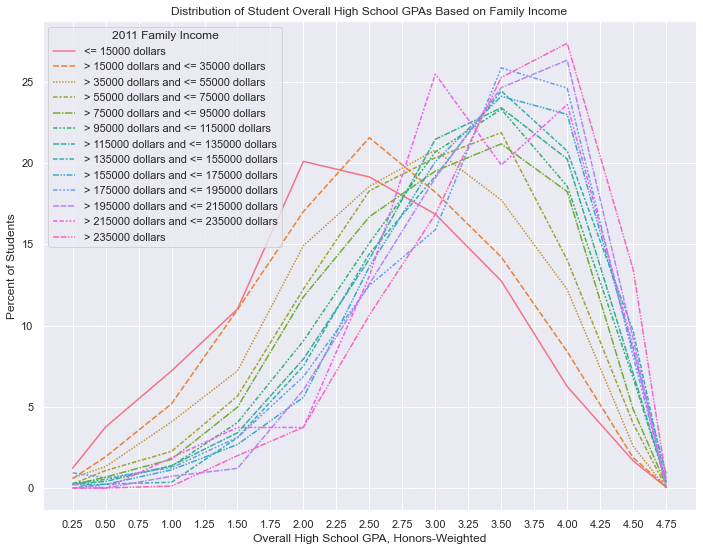

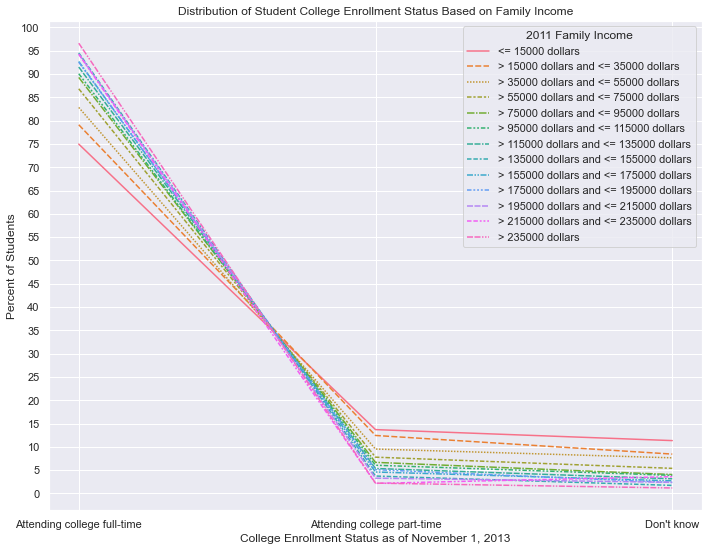

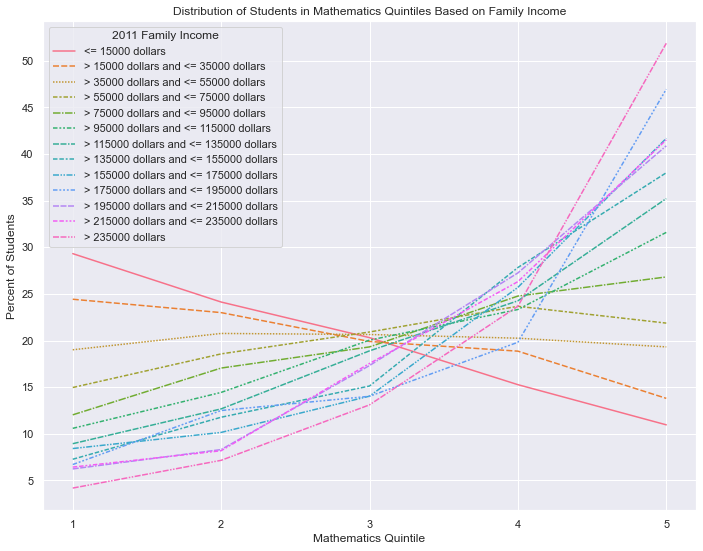

In [22]:
sns.set(rc={'figure.figsize':(11.7, 9)})


# Graph gpas
income_gpas_array = [income1_gpa, income2_gpa, income3_gpa, income4_gpa, income5_gpa, income6_gpa, income7_gpa, 
              income8_gpa, income9_gpa, income10_gpa, income11_gpa, income12_gpa, income13_gpa]

income_gpas = pd.DataFrame()
for i in range(len(income_gpas_array)):
    income_gpas['INCOME BRACKET ' + str(i + 1)] = income_gpas_array[i][gpa_variable]
    income_gpas['INCOME BRACKET ' + str(i + 1) + ' PERCENT'] = income_gpas_array[i]['PERCENT'] 
income_gpas.fillna(0, inplace=True)

income_gpas_percent = income_gpas.filter(regex='PERCENT', axis=1)
plt.figure()
income_gpas_graph = sns.lineplot(data=income_gpas_percent)
income_gpas_graph.set(xlabel='Overall High School GPA, Honors-Weighted', ylabel='Percent of Students')
income_gpas_graph.set_title('Distribution of Student Overall High School GPAs Based on Family Income')
income_gpas_graph.xaxis.set_major_locator(ticker.MultipleLocator(0.25))
for t, l in zip(income_gpas_graph.legend().texts, income_labels): 
    t.set_text(l)
income_gpas_graph.get_legend().set_title("2011 Family Income")
income_gpas_graph.get_figure().savefig("graphs/Income_GPA_LinePlot.png", dpi=400, bbox_inches = 'tight')


# Graph colleges
income_colleges_array = [income1_college, income2_college, income3_college, income4_college, income5_college, 
                       income6_college, income7_college, income8_college, income9_college, income10_college, 
                       income11_college, income12_college, income13_college]

income_colleges = pd.DataFrame()
for i in range(len(income_colleges_array)):
    income_colleges['INCOME BRACKET ' + str(i + 1)] = income_colleges_array[i]['S3CLGFT']
    income_colleges['INCOME BRACKET ' + str(i + 1) + ' PERCENT'] = income_colleges_array[i]['PERCENT']
income_colleges.fillna(0, inplace=True)

income_colleges_percent = income_colleges.filter(regex='PERCENT', axis=1)
plt.figure()
income_colleges_graph = sns.lineplot(data=income_colleges_percent)
income_colleges_graph.set(xlabel='College Enrollment Status as of November 1, 2013', ylabel='Percent of Students')
income_colleges_graph.set_title('Distribution of Student College Enrollment Status Based on Family Income')
income_colleges_graph.xaxis.set_major_locator(ticker.MultipleLocator(1))
income_colleges_graph.set_xticklabels(['', 'Attending college full-time', 'Attending college part-time', "Don't know"])
income_colleges_graph.yaxis.set_major_locator(ticker.MultipleLocator(5))
income_colleges_graph.legend().set_title("Income Brackets")
for t, l in zip(income_colleges_graph.legend().texts, income_labels): 
    t.set_text(l)
income_colleges_graph.get_legend().set_title("2011 Family Income")
income_colleges_graph.get_figure().savefig("graphs/Income_College_LinePlot.png", dpi=400, bbox_inches = 'tight')


# Graph math quintiles
income_math_quints_array = [income1_quint, income2_quint, income3_quint, income4_quint, income5_quint, 
                          income6_quint, income7_quint, income8_quint, income9_quint, income10_quint, 
                          income11_quint, income12_quint, income13_quint]

income_math_quints = pd.DataFrame()
for i in range(len(income_math_quints_array)):
    income_math_quints['INCOME BRACKET ' + str(i + 1)] = income_math_quints_array[i]['X2TXMQUINT']
    income_math_quints['INCOME BRACKET ' + str(i + 1) + ' PERCENT'] = income_math_quints_array[i]['PERCENT']
    
income_math_quints_percent = income_math_quints.filter(regex='PERCENT', axis=1)
plt.figure()
income_math_quints_graph = sns.lineplot(data=income_math_quints_percent)
income_math_quints_graph.set(xlabel='Mathematics Quintile', ylabel='Percent of Students')
income_math_quints_graph.set_title('Distribution of Students in Mathematics Quintiles Based on Family Income')
income_math_quints_graph.xaxis.set_major_locator(ticker.MultipleLocator(1))
income_math_quints_graph.yaxis.set_major_locator(ticker.MultipleLocator(5))
income_math_quints_graph.legend().set_title("Income Brackets")
for t, l in zip(income_math_quints_graph.legend().texts, income_labels): 
    t.set_text(l)
income_math_quints_graph.get_legend().set_title("2011 Family Income")
income_math_quints_graph.get_figure().savefig("graphs/Income_MathQuints_LinePlot.png", dpi=400, bbox_inches = 'tight')

## Academic Measures by Poverty: Math, GPA, and College Attendance<a id='measuresByPoverty'></a>

### Constants and Functions

In [23]:
# Takes in poverty_num from X2POVERTY column. Returns math performance table, 
# math quintile counts, GPA counts, and college status counts
def analyze_poverty(poverty_num):
    poverty = indicators[indicators['X2POVERTY'] == poverty_num]
    poverty_academic = poverty[academic_variables]
    
    poverty_cont = poverty_academic[math_cont_variables].describe()
    
    poverty_quint = poverty_academic[math_quintile].value_counts().to_frame()
    num_drop = len([i for i in poverty_quint.index if i < 0])
    poverty_quint = poverty_quint.sort_index().iloc[num_drop:]
    poverty_quint['PERCENT'] = poverty_quint[math_quintile] / poverty_quint[math_quintile].sum() * 100
    
    poverty_gpa = poverty_academic[gpa_variable].value_counts().to_frame()
    num_drop = len([i for i in poverty_gpa.index if i < 0])
    poverty_gpa = poverty_gpa.sort_index().iloc[num_drop:]
    poverty_gpa['PERCENT'] = poverty_gpa[gpa_variable] / poverty_gpa[gpa_variable].sum() * 100
    
    poverty_college = poverty_academic[college_variable].value_counts().to_frame()
    num_drop = len([i for i in poverty_college.index if i < 0])
    poverty_college = poverty_college.sort_index().iloc[num_drop:]
    poverty_college['PERCENT'] = poverty_college[college_variable] / poverty_college[college_variable].sum() * 100
    
    return poverty_cont, poverty_quint, poverty_gpa, poverty_college

### Above Poverty Level (relative to 100% of census poverty threshold)

In [24]:
above_poverty_cont, above_poverty_quint, above_poverty_gpa, above_poverty_college = analyze_poverty(0)
print(above_poverty_cont, '\n\n', above_poverty_quint, '\n\n', above_poverty_gpa, '\n\n', above_poverty_college)

            X2TXMTH      X2TXMSCR    X2TXMPROF1    X2TXMPROF2    X2TXMPROF3  \
count  17464.000000  17464.000000  17464.000000  17464.000000  17464.000000   
mean       0.690836     67.778786      0.822751      0.686480      0.594471   
std        1.532710     20.924800      1.059831      1.073839      1.077598   
min       -8.000000     -8.000000     -8.000000     -8.000000     -8.000000   
25%        0.098000     56.806125      0.994000      0.786900      0.468600   
50%        0.753650     68.212650      0.999600      0.959050      0.891850   
75%        1.567150     81.973950      1.000000      0.996100      0.995300   
max        4.504600    115.100000      1.000000      1.000000      1.000000   

         X2TXMPROF4    X2TXMPROF5  
count  17464.000000  17464.000000  
mean       0.242189      0.132770  
std        1.042759      1.024573  
min       -8.000000     -8.000000  
25%        0.049400      0.034100  
50%        0.163900      0.046400  
75%        0.699850      0.284750  


### Below Poverty Threshold (relative to 100% of census poverty threshold)

In [25]:
below_poverty_cont, below_poverty_quint, below_poverty_gpa, below_poverty_college = analyze_poverty(1)
print(below_poverty_cont, '\n\n', below_poverty_quint, '\n\n', below_poverty_gpa, '\n\n', below_poverty_college)

           X2TXMTH     X2TXMSCR   X2TXMPROF1   X2TXMPROF2   X2TXMPROF3  \
count  3455.000000  3455.000000  3455.000000  3455.000000  3455.000000   
mean      0.026528    57.331007     0.675398     0.458149     0.335971   
std       1.642398    20.526730     1.371420     1.366708     1.353094   
min      -8.000000    -8.000000    -8.000000    -8.000000    -8.000000   
25%      -0.659650    42.663750     0.892600     0.238200     0.086400   
50%       0.261600    59.726300     0.997000     0.854500     0.600000   
75%       0.828050    69.459850     0.999700     0.966650     0.915700   
max       4.319400   114.445000     1.000000     1.000000     1.000000   

        X2TXMPROF4   X2TXMPROF5  
count  3455.000000  3455.000000  
mean      0.003899    -0.068251  
std       1.278295     1.258827  
min      -8.000000    -8.000000  
25%       0.030400     0.032500  
50%       0.061500     0.035300  
75%       0.195150     0.050450  
max       1.000000     1.000000   

    X2TXMQUINT    PERCENT

### Aggregate Tables and Visualization

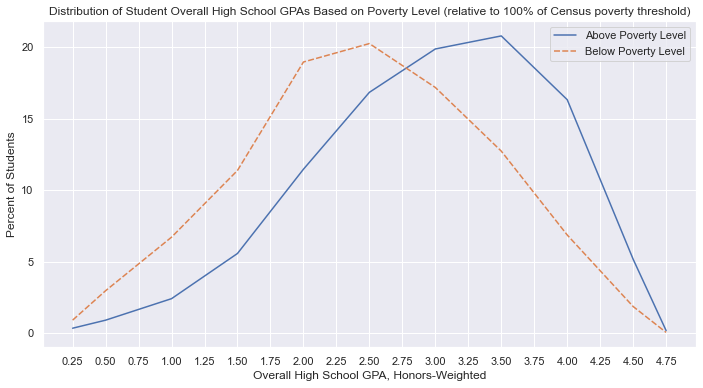

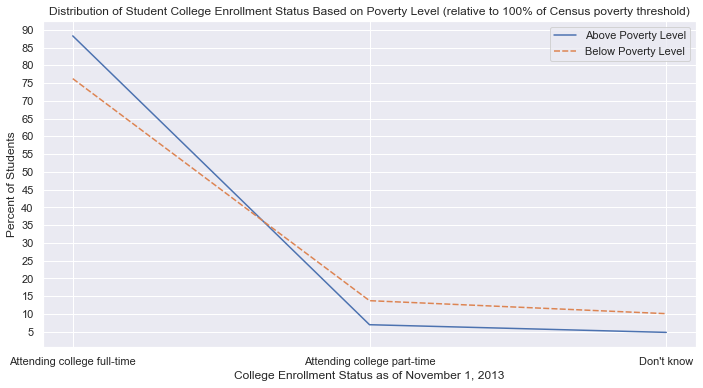

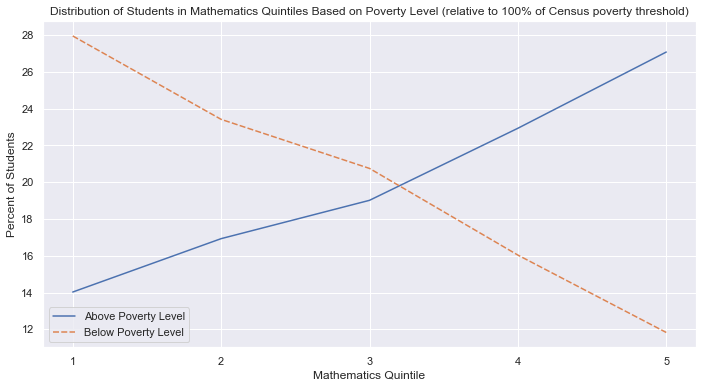

In [26]:
sns.set(rc={'figure.figsize':(11.7, 6)})

poverty_gpas_array = [above_poverty_gpa, below_poverty_gpa]
poverty_labels = ['Above Poverty Level', 'Below Poverty Level']

# Graph GPAs
poverty_gpas = pd.DataFrame()
for i in range(len(poverty_gpas_array)):
    poverty_gpas['POVERTY LEVEL ' + str(i)] = poverty_gpas_array[i][gpa_variable]
    poverty_gpas['POVERTY LEVEL ' + str(i) + ' PERCENT'] = poverty_gpas_array[i]['PERCENT'] 
poverty_gpas.fillna(0, inplace=True)

poverty_gpas_percent = poverty_gpas.filter(regex='PERCENT', axis=1)
plt.figure()
poverty_gpas_graph = sns.lineplot(data=poverty_gpas_percent)
poverty_gpas_graph.set(xlabel='Overall High School GPA, Honors-Weighted', ylabel='Percent of Students')
poverty_gpas_graph.set_title(
    'Distribution of Student Overall High School GPAs Based on Poverty Level (relative to 100% of Census poverty threshold)'
)
poverty_gpas_graph.xaxis.set_major_locator(ticker.MultipleLocator(0.25))
poverty_gpas_graph.yaxis.set_major_locator(ticker.MultipleLocator(5))
for t, l in zip(poverty_gpas_graph.legend().texts, poverty_labels):
    t.set_text(l)
poverty_gpas_graph.get_figure().savefig("graphs/Poverty_GPA_LinePlot.png", dpi=400, bbox_inches = 'tight')


# Graph Colleges
poverty_colleges_array = [above_poverty_college, below_poverty_college]

poverty_colleges = pd.DataFrame()
for i in range(len(poverty_colleges_array)):
    poverty_colleges['POVERTY LEVEL ' + str(i)] = poverty_colleges_array[i]['S3CLGFT']
    poverty_colleges['POVERTY LEVEL ' + str(i) + ' PERCENT'] = poverty_colleges_array[i]['PERCENT']
poverty_colleges.fillna(0, inplace=True)

poverty_colleges_percent = poverty_colleges.filter(regex='PERCENT', axis=1)
plt.figure()
poverty_colleges_graph = sns.lineplot(data=poverty_colleges_percent)
poverty_colleges_graph.set(xlabel='College Enrollment Status as of November 1, 2013', ylabel='Percent of Students')
poverty_colleges_graph.set_title('Distribution of Student College Enrollment Status Based on Poverty Level (relative to 100% of Census poverty threshold)')
poverty_colleges_graph.xaxis.set_major_locator(ticker.MultipleLocator(1))
poverty_colleges_graph.yaxis.set_major_locator(ticker.MultipleLocator(5))
poverty_colleges_graph.set_xticklabels(['', 'Attending college full-time', 'Attending college part-time', "Don't know"])
for t, l in zip(poverty_colleges_graph.legend().texts, poverty_labels): 
    t.set_text(l)
poverty_colleges_graph.get_figure().savefig("graphs/Poverty_College_LinePlot.png", dpi=400, bbox_inches = 'tight')


# Graph math quintiles
poverty_math_quints_array = [above_poverty_quint, below_poverty_quint]

poverty_math_quints = pd.DataFrame()
for i in range(len(poverty_math_quints_array)):
    poverty_math_quints['POVERTY LEVEL ' + str(i)] = poverty_math_quints_array[i]['X2TXMQUINT']
    poverty_math_quints['POVERTY LEVEL ' + str(i) + ' PERCENT'] = poverty_math_quints_array[i]['PERCENT']
    
poverty_math_quints_percent = poverty_math_quints.filter(regex='PERCENT', axis=1)
plt.figure()
poverty_math_quints_graph = sns.lineplot(data=poverty_math_quints_percent)
poverty_math_quints_graph.set(xlabel='Mathematics Quintile', ylabel='Percent of Students')
poverty_math_quints_graph.set_title('Distribution of Students in Mathematics Quintiles Based on Poverty Level (relative to 100% of Census poverty threshold)')
poverty_math_quints_graph.xaxis.set_major_locator(ticker.MultipleLocator(1))
for t, l in zip(poverty_math_quints_graph.legend().texts, poverty_labels): 
    t.set_text(l)
poverty_math_quints_graph.get_figure().savefig("graphs/Poverty_MathQuints_LinePlot.png", dpi=400, bbox_inches = 'tight')

## Additional visualizations: Academic Indicators by Income and Poverty<a id='incpovaddvis'></a>

In [27]:
income_math = indicators[['X2FAMINCOME', 'X2TXMTH']]
income_math = income_math[(income_math['X2FAMINCOME'] > 0) & (income_math['X2TXMTH'] > -8)]
income_math.head()

,X2FAMINCOME,X2TXMTH
0,11,2.6606
1,3,1.0097
2,6,1.1852
4,7,0.6123
5,5,0.9994


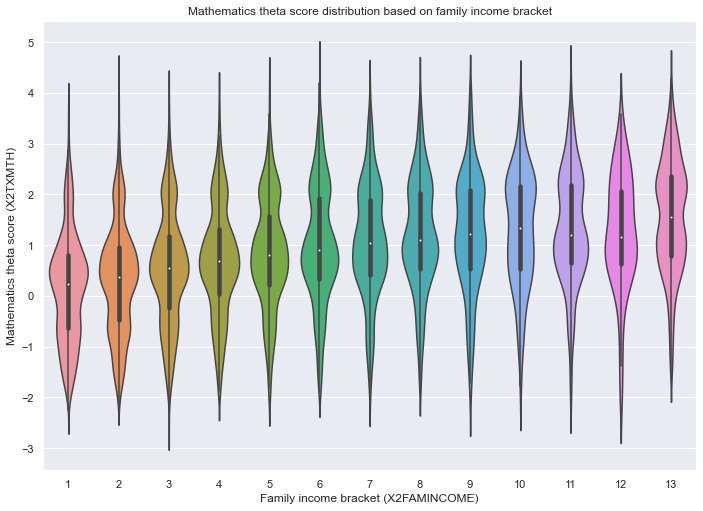

In [28]:
sns.set(rc={'figure.figsize':(11.7, 8.27)})
plt.figure()
income_math_graph = sns.violinplot(x="X2FAMINCOME", y="X2TXMTH", data=income_math)
income_math_graph.set(ylabel="Mathematics theta score (X2TXMTH)", xlabel="Family income bracket (X2FAMINCOME)")
income_math_graph.set_title("Mathematics theta score distribution based on family income bracket")
income_math_graph.get_figure().savefig('graphs/Income_MathTheta_ViolinPlot.png', dpi=400, bbox_inches = 'tight')

In [29]:
income_gpa = indicators[['X2FAMINCOME', gpa_variable]].copy()
income_gpa = income_gpa[(income_gpa['X2FAMINCOME'] > 0) & (income_gpa[gpa_variable] > 0)]
income_gpa = (income_gpa
 .groupby('X2FAMINCOME')[gpa_variable]
 .value_counts(normalize=True)
 .mul(100)
 .rename('Percent')
 .reset_index())
income_gpa.head()

,X2FAMINCOME,X3TGPAWGT,Percent
0,1,2.0,20.101523
1,1,2.5,19.137056
2,1,3.0,16.852792
3,1,3.5,12.741117
4,1,1.5,11.015228


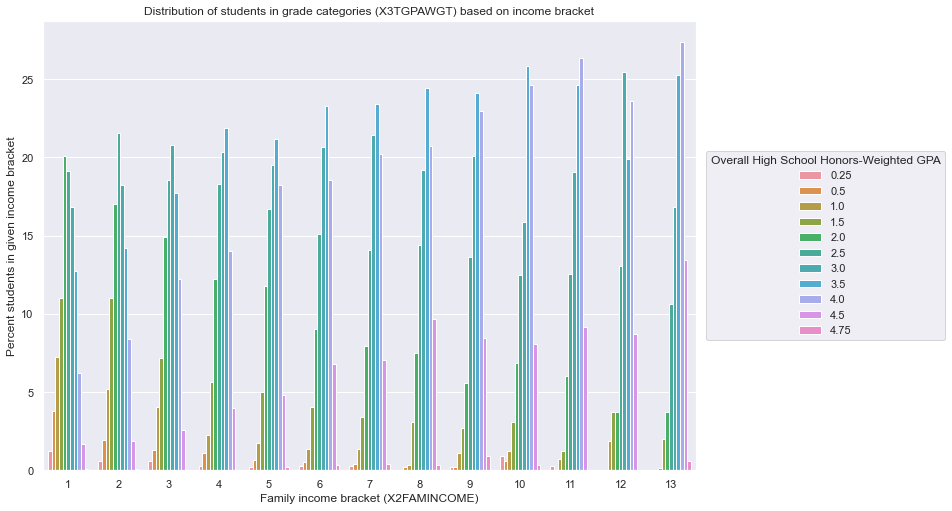

In [30]:
plt.figure()
income_gpa_graph = sns.barplot(x="X2FAMINCOME", y="Percent", hue=gpa_variable, data=income_gpa)
income_gpa_graph.set(xlabel='Family income bracket (X2FAMINCOME)', ylabel='Percent students in given income bracket')
income_gpa_graph.set_title('Distribution of students in grade categories (X3TGPAWGT) based on income bracket')
income_gpa_graph.legend(
    loc='center right', 
    bbox_to_anchor=(1.39, 0.5), ncol=1
).set_title("Overall High School Honors-Weighted GPA")
income_gpa_graph.get_figure().savefig("graphs/Income_GPA_BarPlot.png", dpi=400, bbox_inches = 'tight')

In [31]:
income_college = indicators[['X2FAMINCOME', 'S3CLGFT']].copy()
income_college = income_college[(income_college['X2FAMINCOME'] > 0) & (income_college['S3CLGFT'] > 0)]
income_college = (income_college
 .groupby('X2FAMINCOME')['S3CLGFT']
 .value_counts(normalize=True)
 .mul(100)
 .rename('Percent')
 .reset_index())
income_college.head()

,X2FAMINCOME,S3CLGFT,Percent
0,1,1,74.971942
1,1,2,13.692480
2,1,3,11.335578
3,2,1,79.122710
4,2,2,12.437535


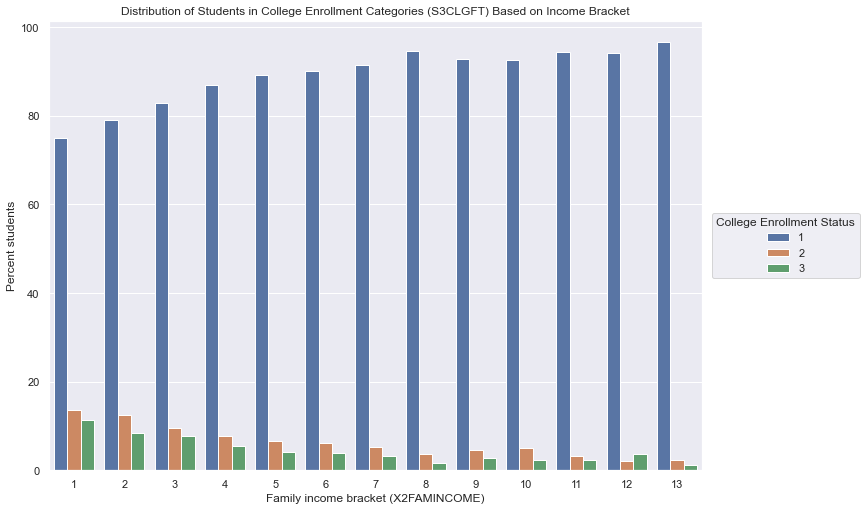

In [32]:
plt.figure()
income_college_graph = sns.barplot(x="X2FAMINCOME", y="Percent", hue="S3CLGFT", data=income_college)
income_college_graph.set(xlabel="Family income bracket (X2FAMINCOME)", ylabel="Percent students")
income_college_graph.set_title(
    'Distribution of Students in College Enrollment Categories (S3CLGFT) Based on Income Bracket'
)
new_labels = ['Attending College Full-Time', 'Attending College Part-Time', "Don't Know"]
for t, l in zip(income_college_graph.legend().texts, new_labels): 
    t.set_text(l)
income_college_graph.legend(
    loc='center right', 
    bbox_to_anchor=(1.25, 0.5), ncol=1
).set_title("College Enrollment Status")
income_college_graph.get_figure().savefig("graphs/Income_College_BarPlot.png", dpi=400, bbox_inches = 'tight')

In [33]:
poverty_math = indicators[['X2POVERTY', 'X2TXMTH']]
poverty_math = poverty_math[(poverty_math['X2POVERTY'] >= 0) & (poverty_math['X2TXMTH'] > -8)]
poverty_math.head()

,X2POVERTY,X2TXMTH
0,0,2.6606
1,0,1.0097
2,0,1.1852
4,0,0.6123
5,0,0.9994


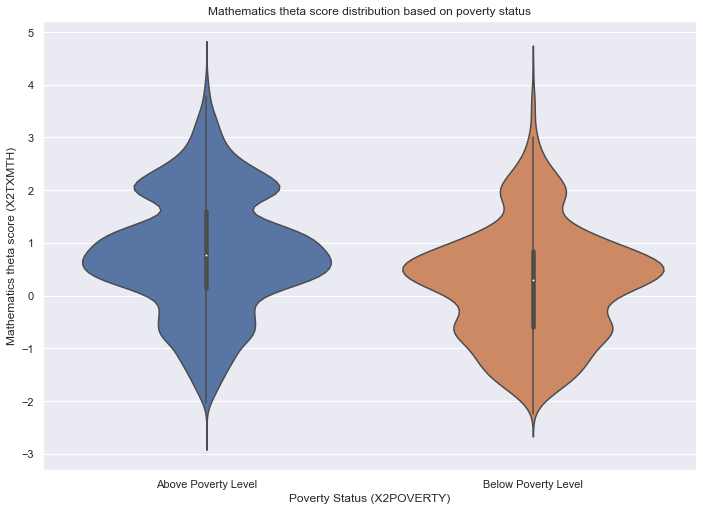

In [34]:
plt.figure()
poverty_math_graph = sns.violinplot(x="X2POVERTY", y="X2TXMTH", data=poverty_math)
poverty_math_graph.set(ylabel="Mathematics theta score (X2TXMTH)", xlabel="Poverty Status (X2POVERTY)")
poverty_math_graph.set_title("Mathematics theta score distribution based on poverty status")
poverty_math_graph.set_xticklabels(["Above Poverty Level", 'Below Poverty Level'])
poverty_math_graph.get_figure().savefig("graphs/Poverty_Math_ViolinPlot.png", dpi=400, bbox_inches = 'tight')

In [35]:
poverty_gpa = indicators[['X2POVERTY', gpa_variable]].copy()
poverty_gpa = poverty_gpa[(poverty_gpa['X2POVERTY'] >= 0) & (poverty_gpa[gpa_variable] > 0)]
poverty_gpa.head()

,X2POVERTY,X3TGPAWGT
0,0,3.5
1,0,4.0
2,0,3.5
3,0,4.5
4,0,3.5


[Text(0, 0, 'Above Poverty Level'), Text(1, 0, 'Below Poverty Level')]

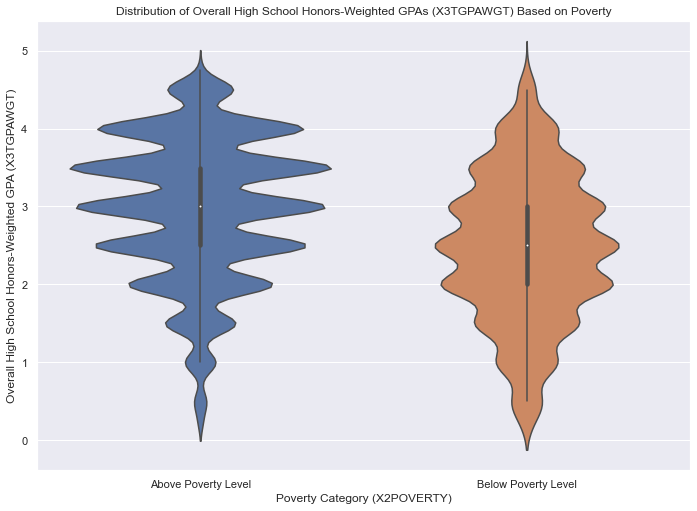

In [36]:
plt.figure()
poverty_gpa_graph = sns.violinplot(x="X2POVERTY", y=gpa_variable, data=poverty_gpa)
poverty_gpa_graph.set(xlabel='Poverty Category (X2POVERTY)', 
                      ylabel='Overall High School Honors-Weighted GPA (X3TGPAWGT)')
poverty_gpa_graph.set_title('Distribution of Overall High School Honors-Weighted GPAs (X3TGPAWGT) Based on Poverty')
poverty_gpa_graph.set_xticklabels(["Above Poverty Level", 'Below Poverty Level'])

In [37]:
poverty_college = indicators[['X2POVERTY', 'S3CLGFT']].copy()
poverty_college = poverty_college[(poverty_college['X2POVERTY'] >= 0) & (poverty_college['S3CLGFT'] > 0)]
poverty_college = (poverty_college
 .groupby('X2POVERTY')['S3CLGFT']
 .value_counts(normalize=True)
 .mul(100)
 .rename('Percent')
 .reset_index())
poverty_college.head()

,X2POVERTY,S3CLGFT,Percent
0,0,1,88.282490
1,0,2,6.938811
2,0,3,4.778699
3,1,1,76.240209
4,1,2,13.707572


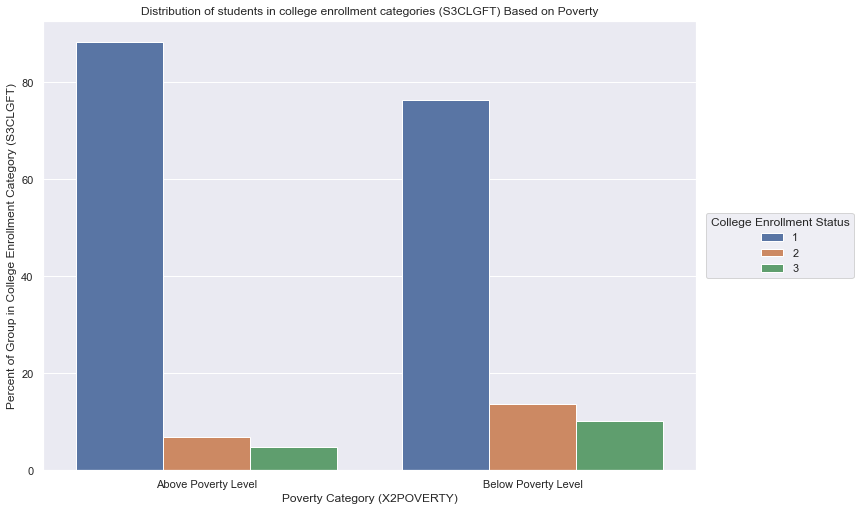

In [38]:
plt.figure()
poverty_college_graph = sns.barplot(x="X2POVERTY", y="Percent", hue="S3CLGFT", data=poverty_college)
poverty_college_graph.set(xlabel='Poverty Category (X2POVERTY)', 
                          ylabel='Percent of Group in College Enrollment Category (S3CLGFT)')
poverty_college_graph.set_title('Distribution of students in college enrollment categories (S3CLGFT) Based on Poverty')
poverty_college_graph.set_xticklabels(["Above Poverty Level", 'Below Poverty Level'])
new_labels = ['Attending College Full-Time', 'Attending College Part-Time', "Don't Know"]
for t, l in zip(poverty_college_graph.legend().texts, new_labels): 
    t.set_text(l)
poverty_college_graph.legend(
    loc='center right', 
    bbox_to_anchor=(1.25, 0.5), ncol=1
).set_title("College Enrollment Status")

## Academic Measures by Race: Math, GPA, and College Attendance<a id='measuresByRace'></a>

### Constants and Functions

In [39]:
def analyze_race(race_num):
    race = indicators[indicators['X1RACE'] == race_num]
    race_academic = race[academic_variables]
    
    race_cont = race_academic[math_cont_variables].describe()
    
    race_quint = race_academic[math_quintile].value_counts().to_frame()
    num_drop = len([i for i in race_quint.index if i < 0])
    race_quint = race_quint.sort_index().iloc[num_drop:]
    race_quint['PERCENT'] = race_quint[math_quintile] / race_quint[math_quintile].sum() * 100
    
    race_gpa = race_academic[gpa_variable].value_counts().to_frame()
    num_drop = len([i for i in race_gpa.index if i < 0])
    race_gpa = race_gpa.sort_index().iloc[num_drop:]
    race_gpa['PERCENT'] = race_gpa[gpa_variable] / race_gpa[gpa_variable].sum() * 100
    
    race_college = race_academic[college_variable].value_counts().to_frame()
    num_drop = len([i for i in race_college.index if i < 0])
    race_college = race_college.sort_index().iloc[num_drop:]
    race_college['PERCENT'] = race_college[college_variable] / race_college[college_variable].sum() * 100
    
    return race_cont, race_quint, race_gpa, race_college

### American Indian / Alaskan Native

In [40]:
native_cont, native_quint, native_gpa, native_college = analyze_race(1)
print(native_cont, '\n\n', native_quint, '\n\n', native_gpa, '\n\n', native_college)

          X2TXMTH    X2TXMSCR  X2TXMPROF1  X2TXMPROF2  X2TXMPROF3  X2TXMPROF4  \
count  165.000000  165.000000  165.000000  165.000000  165.000000  165.000000   
mean    -1.707981   43.450105   -1.227844   -1.389261   -1.480184   -1.719457   
std      3.660987   33.442659    3.785805    3.703465    3.654166    3.515158   
min     -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   
25%     -1.981200   27.512100    0.058600    0.020500    0.020200    0.026600   
50%     -0.243900   50.457000    0.976600    0.563300    0.232200    0.036600   
75%      0.690500   67.147700    0.999500    0.951400    0.867600    0.141500   
max      3.366100  107.728000    1.000000    1.000000    1.000000    0.998700   

       X2TXMPROF5  
count  165.000000  
mean    -1.774928  
std      3.482335  
min     -8.000000  
25%      0.032300  
50%      0.033000  
75%      0.043800  
max      0.999700   

    X2TXMQUINT    PERCENT
1          37  29.365079
2          27  21.428571
3          2

### Asian, non-Hispanic

In [41]:
asian_cont, asian_quint, asian_gpa, asian_college = analyze_race(2)
print(asian_cont, '\n\n', asian_quint, '\n\n', asian_gpa, '\n\n', asian_college)

           X2TXMTH     X2TXMSCR   X2TXMPROF1   X2TXMPROF2   X2TXMPROF3  \
count  1952.000000  1952.000000  1952.000000  1952.000000  1952.000000   
mean      0.312349    69.065429    -0.156415    -0.217385    -0.267127   
std       3.358732    34.459953     2.987548     2.969449     2.954640   
min      -8.000000    -8.000000    -8.000000    -8.000000    -8.000000   
25%       0.257450    59.653100     0.996900     0.853075     0.596750   
50%       1.204200    75.744450     0.999900     0.988650     0.979150   
75%       2.307775    94.284875     1.000000     0.999600     0.999800   
max       4.319400   114.445000     1.000000     1.000000     1.000000   

        X2TXMPROF4   X2TXMPROF5  
count  1952.000000  1952.000000  
mean     -0.513747    -0.607701  
std       2.873813     2.842092  
min      -8.000000    -8.000000  
25%       0.061100     0.035200  
50%       0.434500     0.101250  
75%       0.956275     0.925600  
max       1.000000     1.000000   

    X2TXMQUINT    PERCENT

### Black/African-American, non-Hispanic

In [42]:
black_cont, black_quint, black_gpa, black_college = analyze_race(3)
print(black_cont, '\n\n', black_quint, '\n\n', black_gpa, '\n\n', black_college)

           X2TXMTH     X2TXMSCR   X2TXMPROF1   X2TXMPROF2   X2TXMPROF3  \
count  2450.000000  2450.000000  2450.000000  2450.000000  2450.000000   
mean     -0.906838    49.459327    -0.292829    -0.493856    -0.605332   
std       2.935291    27.484603     3.032114     2.965303     2.923933   
min      -8.000000    -8.000000    -8.000000    -8.000000    -8.000000   
25%      -0.959525    37.838000     0.734025     0.117650     0.047425   
50%       0.082250    56.520800     0.993650     0.779150     0.456050   
75%       0.716400    67.584700     0.999500     0.954675     0.878000   
max       3.937000   112.580000     1.000000     1.000000     1.000000   

        X2TXMPROF4   X2TXMPROF5  
count  2450.000000  2450.000000  
mean     -0.910332    -0.977727  
std       2.792978     2.762899  
min      -8.000000    -8.000000  
25%       0.028500     0.032400  
50%       0.048550     0.034000  
75%       0.150225     0.044800  
max       0.999800     1.000000   

    X2TXMQUINT    PERCENT

### Hispanic, no race specified

In [43]:
hispanicnr_cont, hispanicnr_quint, hispanicnr_gpa, hispanicnr_college = analyze_race(4)
print(hispanicnr_cont, '\n\n', hispanicnr_quint, '\n\n', hispanicnr_gpa, '\n\n', hispanicnr_college)

          X2TXMTH    X2TXMSCR  X2TXMPROF1  X2TXMPROF2  X2TXMPROF3  X2TXMPROF4  \
count  422.000000  422.000000  422.000000  422.000000  422.000000  422.000000   
mean    -1.348619   45.323417   -0.711727   -0.912831   -1.025981   -1.310077   
std      3.240610   29.062777    3.425507    3.341299    3.289626    3.146188   
min     -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   
25%     -1.219550   34.358350    0.520425    0.069700    0.032625    0.027600   
50%     -0.126300   52.681300    0.985250    0.653350    0.302700    0.039750   
75%      0.578525   65.244850    0.999200    0.934500    0.814725    0.110275   
max      3.014700  103.622000    1.000000    1.000000    1.000000    0.995500   

       X2TXMPROF5  
count  422.000000  
mean    -1.366109  
std      3.117355  
min     -8.000000  
25%      0.032400  
50%      0.033200  
75%      0.040275  
max      0.998200   

    X2TXMQUINT    PERCENT
1         102  29.479769
2          91  26.300578
3          6

### Hispanic, race specified

In [44]:
hispanicrs_cont, hispanicrs_quint, hispanicrs_gpa, hispanicrs_college = analyze_race(5)
print(hispanicrs_cont, '\n\n', hispanicrs_quint, '\n\n', hispanicrs_gpa, '\n\n', hispanicrs_college)

           X2TXMTH     X2TXMSCR   X2TXMPROF1   X2TXMPROF2   X2TXMPROF3  \
count  3375.000000  3375.000000  3375.000000  3375.000000  3375.000000   
mean     -0.858728    51.648485    -0.437956    -0.599705    -0.702910   
std       3.178668    30.034755     3.214001     3.155529     3.115247   
min      -8.000000    -8.000000    -8.000000    -8.000000    -8.000000   
25%      -0.874400    39.113850     0.789850     0.142300     0.055300   
50%       0.281000    60.069300     0.997200     0.861200     0.615200   
75%       0.902150    70.696800     0.999800     0.972900     0.934900   
max       3.728300   111.144000     1.000000     1.000000     1.000000   

        X2TXMPROF4   X2TXMPROF5  
count  3375.000000  3375.000000  
mean     -1.018749    -1.094590  
std       2.975866     2.940604  
min      -8.000000    -8.000000  
25%       0.028950     0.032400  
50%       0.063300     0.035400  
75%       0.231950     0.055700  
max       0.999600     1.000000   

    X2TXMQUINT    PERCENT

### More than one race, non-Hispanic

In [45]:
more_cont, more_quint, more_gpa, more_college = analyze_race(6)
print(more_cont, '\n\n', more_quint, '\n\n', more_gpa, '\n\n', more_college)

           X2TXMTH     X2TXMSCR   X2TXMPROF1   X2TXMPROF2   X2TXMPROF3  \
count  1941.000000  1941.000000  1941.000000  1941.000000  1941.000000   
mean     -0.465714    57.090387    -0.274587    -0.407028    -0.492103   
std       3.165738    31.071136     3.075955     3.033442     3.004322   
min      -8.000000    -8.000000    -8.000000    -8.000000    -8.000000   
25%      -0.626900    43.246000     0.903900     0.258100     0.093100   
50%       0.529200    64.397600     0.999000     0.925400     0.787200   
75%       1.241700    76.376000     0.999900     0.989800     0.982100   
max       4.027700   113.100000     1.000000     1.000000     1.000000   

        X2TXMPROF4   X2TXMPROF5  
count  1941.000000  1941.000000  
mean     -0.806316    -0.901412  
std       2.879486     2.839203  
min      -8.000000    -8.000000  
25%       0.030700     0.032500  
50%       0.099400     0.039100  
75%       0.463300     0.111500  
max       0.999900     1.000000   

    X2TXMQUINT    PERCENT

### Native Hawaiian / Pacific Islander, non-Hispanic

In [46]:
pacific_cont, pacific_quint, pacific_gpa, pacific_college = analyze_race(7)
print(pacific_cont, '\n\n', pacific_quint, '\n\n', pacific_gpa, '\n\n', pacific_college)

          X2TXMTH    X2TXMSCR  X2TXMPROF1  X2TXMPROF2  X2TXMPROF3  X2TXMPROF4  \
count  110.000000  110.000000  110.000000  110.000000  110.000000  110.000000   
mean    -1.058559   50.929174   -0.767678   -0.906938   -1.009055   -1.301302   
std      3.533272   33.258923    3.532059    3.472573    3.425954    3.283336   
min     -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   -8.000000   
25%     -1.078900   36.169175    0.642125    0.091800    0.039325    0.028050   
50%      0.237250   59.294350    0.996650    0.845700    0.580600    0.059350   
75%      0.892750   70.540100    0.999800    0.972150    0.932675    0.226925   
max      3.994400  112.916000    1.000000    1.000000    1.000000    0.999900   

       X2TXMPROF5  
count  110.000000  
mean    -1.369143  
std      3.247707  
min     -8.000000  
25%      0.032400  
50%      0.035050  
75%      0.054950  
max      1.000000   

    X2TXMQUINT    PERCENT
1          13  14.606742
2          28  31.460674
3          1

### White, non-Hispanic

In [47]:
white_cont, white_quint, white_gpa, white_college = analyze_race(8)
print(white_cont, '\n\n', white_quint, '\n\n', white_gpa, '\n\n', white_college)

            X2TXMTH      X2TXMSCR    X2TXMPROF1    X2TXMPROF2    X2TXMPROF3  \
count  12082.000000  12082.000000  12082.000000  12082.000000  12082.000000   
mean      -0.223740     59.839865     -0.105731     -0.223450     -0.303146   
std        3.027449     30.419198      2.884073      2.850997      2.826690   
min       -8.000000     -8.000000     -8.000000     -8.000000     -8.000000   
25%       -0.431000     46.883175      0.952225      0.404900      0.148350   
50%        0.638500     66.267200      0.999400      0.944100      0.844600   
75%        1.413875     79.308900      1.000000      0.993900      0.991100   
max        4.504600    115.100000      1.000000      1.000000      1.000000   

         X2TXMPROF4    X2TXMPROF5  
count  12082.000000  12082.000000  
mean      -0.620554     -0.722474  
std        2.713169      2.673951  
min       -8.000000     -8.000000  
25%        0.033100      0.032700  
50%        0.125800      0.042000  
75%        0.594600      0.180975  


### Aggregate Tables and Visualization

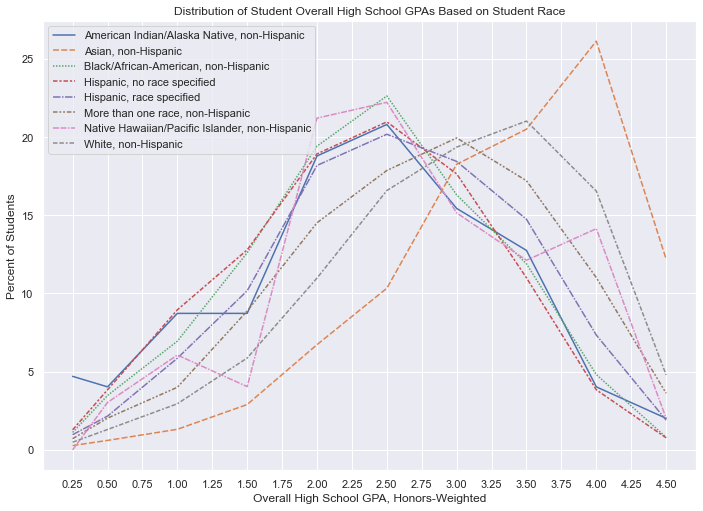

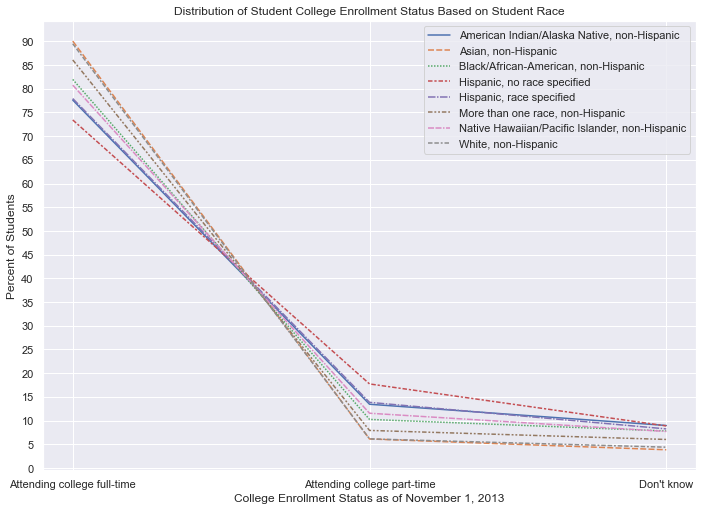

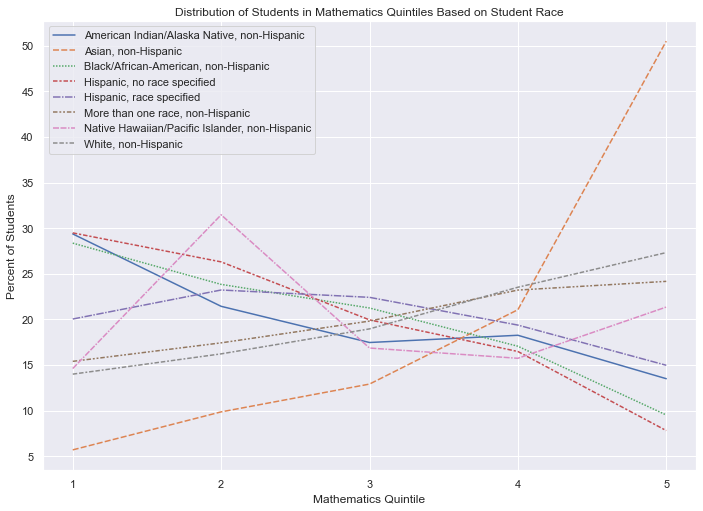

In [48]:
race_labels = ["American Indian/Alaska Native, non-Hispanic", 'Asian, non-Hispanic', 
               'Black/African-American, non-Hispanic', 'Hispanic, no race specified',
               'Hispanic, race specified', 'More than one race, non-Hispanic', 
               'Native Hawaiian/Pacific Islander, non-Hispanic', 'White, non-Hispanic']

# Graph GPAs
race_gpas_array = [native_gpa, asian_gpa, black_gpa, hispanicnr_gpa, hispanicrs_gpa, more_gpa, pacific_gpa, white_gpa]
race_gpas = pd.DataFrame()
for i in range(len(race_gpas_array)):
    race_gpas['RACE ' + str(i+1)] = race_gpas_array[i][gpa_variable]
    race_gpas['RACE ' + str(i+1) + ' PERCENT'] = race_gpas_array[i]['PERCENT'] 
race_gpas.fillna(0, inplace=True)

race_gpas_percent = race_gpas.filter(regex='PERCENT', axis=1)
plt.figure()
race_gpas_graph = sns.lineplot(data=race_gpas_percent)
race_gpas_graph.set(xlabel='Overall High School GPA, Honors-Weighted', ylabel='Percent of Students')
race_gpas_graph.set_title('Distribution of Student Overall High School GPAs Based on Student Race')
race_gpas_graph.xaxis.set_major_locator(ticker.MultipleLocator(0.25))
for t, l in zip(race_gpas_graph.legend().texts, race_labels): 
    t.set_text(l)
race_gpas_graph.get_figure().savefig("graphs/Race_GPA_LinePlot.png", dpi=400, bbox_inches = 'tight')


# Graph colleges
race_colleges_array = [native_college, asian_college, black_college, hispanicnr_college, hispanicrs_college, 
                       more_college, pacific_college, white_college]

race_colleges = pd.DataFrame()
for i in range(len(race_colleges_array)):
    race_colleges['RACE ' + str(i+1)] = race_colleges_array[i]['S3CLGFT']
    race_colleges['RACE ' + str(i+1) + ' PERCENT'] = race_colleges_array[i]['PERCENT'] 
race_colleges.fillna(0, inplace=True)

race_colleges_percent = race_colleges.filter(regex='PERCENT', axis=1)
plt.figure()
race_colleges_graph = sns.lineplot(data=race_colleges_percent)
race_colleges_graph.set(xlabel='College Enrollment Status as of November 1, 2013', ylabel='Percent of Students')
race_colleges_graph.set_title('Distribution of Student College Enrollment Status Based on Student Race')
race_colleges_graph.xaxis.set_major_locator(ticker.MultipleLocator(1))
race_colleges_graph.set_xticklabels(['', 'Attending college full-time', 'Attending college part-time', "Don't know"])
race_colleges_graph.yaxis.set_major_locator(ticker.MultipleLocator(5))
for t, l in zip(race_colleges_graph.legend().texts, race_labels): 
    t.set_text(l)
race_colleges_graph.get_figure().savefig("graphs/Race_College_LinePlot.png", dpi=400, bbox_inches = 'tight')


# Graph math quintiles
race_math_quints_array = [native_quint, asian_quint, black_quint, hispanicnr_quint, hispanicrs_quint, 
                       more_quint, pacific_quint, white_quint]

race_math_quints = pd.DataFrame()
for i in range(len(race_math_quints_array)):
    race_math_quints['RACE ' + str(i+1)] = race_math_quints_array[i]['X2TXMQUINT']
    race_math_quints['RACE ' + str(i+1) + ' PERCENT'] = race_math_quints_array[i]['PERCENT'] 
race_math_quints.fillna(0, inplace=True)

race_math_quints_percent = race_math_quints.filter(regex='PERCENT', axis=1)
plt.figure()
race_math_quints_graph = sns.lineplot(data=race_math_quints_percent)
race_math_quints_graph.set(xlabel='Mathematics Quintile', ylabel='Percent of Students')
race_math_quints_graph.set_title('Distribution of Students in Mathematics Quintiles Based on Student Race')
race_math_quints_graph.xaxis.set_major_locator(ticker.MultipleLocator(1))
race_math_quints_graph.yaxis.set_major_locator(ticker.MultipleLocator(5))
for t, l in zip(race_math_quints_graph.legend().texts, race_labels): 
    t.set_text(l)
race_math_quints_graph.get_figure().savefig("graphs/Race_MathQuints_LinePlot.png", dpi=400, bbox_inches = 'tight')

## Conclusions<a id='conclusions'></a>
There is a clear positive correlation between income and academic performance. People of higher income are associated with a higher mathematics quintile score, general mathematics proficiency measured by the HSLS First Follow-up math assessment, overall high school GPA, and chance of enrolling in college full-time as of November 2013 given that the student was in 9th grade in the fall of 2009. In addition, students in poverty (relative to the US Census 100% poverty threshold) tend to earn lower overall high school grades, have a decreased chance of enrolling in college full-time, and have reduced mathematics proficiency. In fact, when looking at the mathematics quintile distribution for students above the poverty line versus those below the poverty line, there is a negative and positive association, respectively, between the number of students in a particular mathematics quintile relative to how high that mathematics quintile is.

In terms of race, Asians vastly outperform students of other races in terms of mathematical ability and overall high school grades. People of color, especially those of Hispanic and African American origin, and with the exception of those of Asian descent, are associated with lower mathematics proficiency, probability of enrolling in college full-time, and lower overall high school grades. With the exception of those of Asian, White, and mixed-race descent (and not of Hispanic origin), there is a negative association between the number of students in a particular mathematics quintile relative to how high that mathematics quintile is.

### Possible hypotheses explaining correlations between income, poverty and academic performance
- High family income provides social stability for the student.
    - No need to take on full- or part-time jobs.
    - Better social influences and environmental factors. Influence of drugs and alcohol from parents may be greatly reduced. Likely to grow up in affluent neighborhoods and enroll in good school districts.
    - Students in poor socioeconomic standings may need to dedicate time away from school in order to help support their families.
    - Free time allows the student to engage with friends and extracurricular activities. Improves academic and social efficacy.
    - Ability to afford extracurricular enrichment. e.g. music, academic tutoring, traveling and community service abroad.
- Greater ability to afford college tuition.

### Possible hypotheses explaining correlations between race and academic performance
- Socioeconomic factors
    - People of color generally have reduced incomes and face higher unemployment rates than those of the general population, with the notable exception of people who identify as being White or Asian. (See the analysis done for the Basic Month Current Population Survey.)
    - There may be bias against people of color in the public education system. For example, people of color who aren't as socioeconomically affluent may not be able to live near good school districts or afford educational enrichment opportunities. Students of color in low socioeconomic standings may not be able to dedicate time to school if they are forced to help support their families. There may also be behavioral bias against people of color in the public education system by teachers or school administrators.

## Limitations

Some aspects of this study were limited by the dataset used:
- Because the HSLS dataset used is a publicly available dataset released by the NCES, some variables such as SAT and other standardized test scores have been supressed, limiting the scope of this study.
- Some variables have high numbers of non-respondents and N/A respondents: 
    - S3CLGFT had approximately 43 percent non-respondents and N/A respondents.